# SMS Spam or Ham Classifier

#### Overview 
*In this notebook we are going to use different Machine Learning Algorithms(`Naive bayes`,`Random forest`,`SVM`,`Decision tree`) to predict whether or not a Message is Spam.*

#### Will use the following steps to predict Spam messages
- *Loading the dataset*
- *Exploratory Data Analysis* 
- *Text Processing and feature Engineering*
- *Modeling and Evaluation* 
- *Generate insights* 

#### Dataset 
The Dataset is taken from kaggle.
**Link of the dataset:** *[https://www.kaggle.com/uciml/sms-spam-collection-dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset)*

## Importing required libraries 

In [29]:
# libraries for data operations 
import pandas as pd 
import numpy as np 
# libraries for visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# libraries for performing NLP 
import nltk
import re
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
# libraries for model building and evaluation 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn import metrics


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\astha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\astha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset 

In [30]:
#loding the dataset
sms_data = pd.read_csv("spam.csv",encoding='latin-1')
sms_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [31]:
# creating a copy of the dataset so that the changes will not affect the orignal dataset.
sms_df = sms_data.copy()

In [32]:
# Dropping the redundent looking columns (for this project)
to_drop = ["Unnamed: 2","Unnamed: 3","Unnamed: 4"]
sms_df = sms_df.drop(sms_df[to_drop], axis=1)
# Renaming the columns for better understanding 
sms_df.rename(columns = {"v1":"Target", "v2":"Message"}, inplace = True)
sms_df.head() 

,Target,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Data Exploration 

In [33]:
# checking shape of the data 
sms_df.shape

(5572, 2)

In [15]:
# checking columns name of the dataset
sms_df.columns

Index(['Target', 'Message'], dtype='object')

In [17]:
# datatype
sms_df.dtypes

Target     object
Message    object
dtype: object

In [18]:
# we can also use the info() method to check the basic info about the dataset.
sms_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Target   5572 non-null   object
 1   Message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [19]:
# statistical info of dataset
sms_df.describe()

,Target,Message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


**The dataset consists of 5,572 messages in English. The data is designated as being ham or spam. Dataframe has two columns. The first column is "Target" indicating the class of message as ham or spam and the second "Message" column is the string of text.There is no null values present in the dataset.**

In [34]:
# Mapping Values for labels 
sms_df['Target'] = sms_df['Target'].map({'ham': 0, 'spam': 1})
sms_df.head()

,Target,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


**Replaced the values with 0 and 1, 0:ham and 1:spam**

Text(0, 0.5, 'Number of Data points')

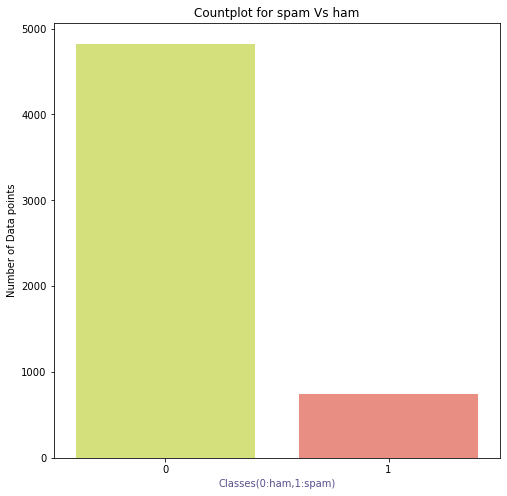

In [35]:
#Palette
cols= ["#E1F16A", "salmon"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(8,8))
fg = sns.countplot(x= sms_df["Target"], palette= cols)
fg.set_title("Countplot for spam Vs ham")
fg.set_xlabel("Classes(0:ham,1:spam)", color="#58508d")
fg.set_ylabel("Number of Data points")

**Insight: From the above countplot, it is evident that the dataset is imbalanced.**

## Feature Engineering 

- Handling imbalanced dataset using Oversampling 
- creating new feautres like: 
  - word_count : Number of words in the text message
  - sentence_count : Number of sentence in the text message
  - contains_currency_symbol : symbols like '€', '$', '¥', '£', '₹' in the text message
  
  

In [36]:
# Handling imbalanced dataset using Oversampling
only_spam = sms_df[sms_df['Target']==1]
print('Number of Spam records: {}'.format(only_spam.shape[0]))
print('Number of Ham records: {}'.format(sms_df.shape[0]-only_spam.shape[0]))

Number of Spam records: 747
Number of Ham records: 4825


In [37]:
count = int((sms_df.shape[0]-only_spam.shape[0])/only_spam.shape[0])
for i in range(0, count-1):
    sms_df = pd.concat([sms_df, only_spam])

sms_df.shape

(9307, 2)

Text(0, 0.5, 'Number of Data points')

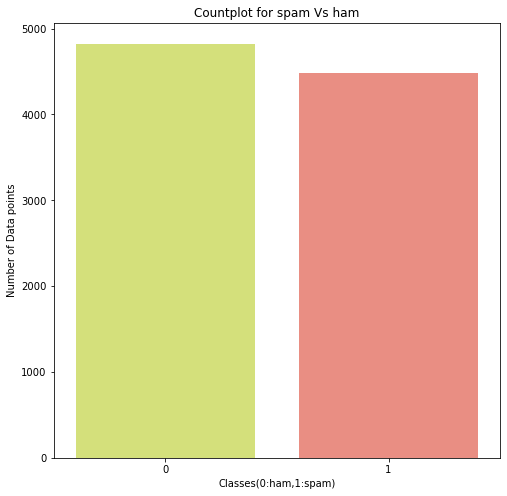

In [38]:
#Palette
cols= ["#E1F16A", "salmon"] 
#first of all let us evaluate the target and find out if our data is imbalanced or not
plt.figure(figsize=(8,8))
fg = sns.countplot(x= sms_df["Target"], palette= cols)
fg.set_title("Countplot for spam Vs ham")
fg.set_xlabel("Classes(0:ham,1:spam)")
fg.set_ylabel("Number of Data points")

**Now our dataset is almost balanced**

In [39]:
# creating new feautre word_count
sms_df['word_count'] = sms_df['Message'].apply(lambda x: len(x.split()))
sms_df.head()

,Target,Message,word_count
0,0,"Go until jurong point, crazy.. Available only ...",20
1,0,Ok lar... Joking wif u oni...,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,0,U dun say so early hor... U c already then say...,11
4,0,"Nah I don't think he goes to usf, he lives aro...",13


C:\Users\astha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\astha\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


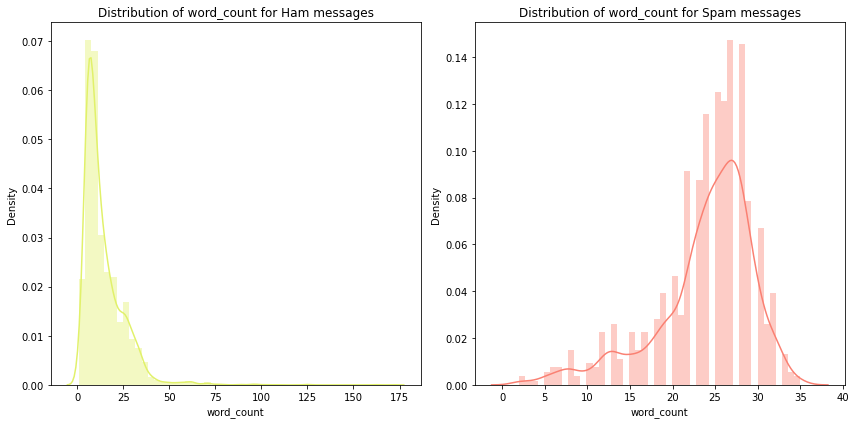

In [40]:
plt.figure(figsize=(12, 6))

# 1-row, 2-column, go to the first subplot
plt.subplot(1, 2, 1)
g = sns.distplot(a=sms_df[sms_df['Target']==0].word_count,color='#E1F16A')
p = plt.title('Distribution of word_count for Ham messages')

# 1-row, 2-column, go to the second subplot
plt.subplot(1, 2, 2)
g = sns.distplot(a=sms_df[sms_df['Target']==1].word_count, color='salmon')
p = plt.title('Distribution of word_count for Spam messages')

plt.tight_layout()
plt.show()


**Insight: Spam messages wordcount fall in the range of 15-30 words, whereas majority of the Ham messages fall in the range of below 25 words.**

In [41]:
# Creating feature contains_currency_symbol
def currency(x):
    currency_symbols = ['€', '$', '¥', '£', '₹']
    for i in currency_symbols:
        if i in x:
            return 1
    return 0

sms_df['contains_currency_symbol'] = sms_df['Message'].apply(currency)

In [42]:
sms_df.tail()

,Target,Message,word_count,contains_currency_symbol
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...,16,0
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...,33,1
5547,1,Had your contract mobile 11 Mnths? Latest Moto...,28,0
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...,28,0
5567,1,This is the 2nd time we have tried 2 contact u...,30,1


Text(0, 0.5, 'Number of Data points')

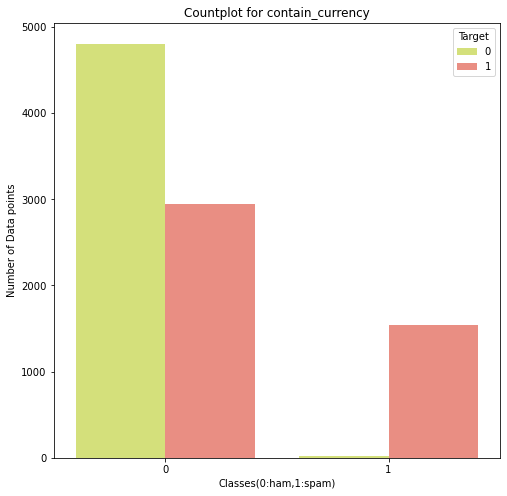

In [43]:
#Palette
cols= ["#E1F16A", "salmon"] 
#countplot for contains_currency_symbol
plt.figure(figsize=(8,8))
fg = sns.countplot(x='contains_currency_symbol', data=sms_df, hue='Target', palette= cols)
fg.set_title("Countplot for contain_currency")
fg.set_xlabel("Classes(0:ham,1:spam)")
fg.set_ylabel("Number of Data points")

**Insight: Almost 1/3 of Spam messages contain currency symbols, and currency symbols are rarely used in Ham messages.**

In [44]:
# Creating feature contains_number
def numbers(x):
    for i in x:
        if ord(i)>=48 and ord(i)<=57:
            return 1
    return 0

sms_df['contains_number'] = sms_df['Message'].apply(numbers)

In [45]:
sms_df.head()

,Target,Message,word_count,contains_currency_symbol,contains_number
0,0,"Go until jurong point, crazy.. Available only ...",20,0,0
1,0,Ok lar... Joking wif u oni...,6,0,0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,28,0,1
3,0,U dun say so early hor... U c already then say...,11,0,0
4,0,"Nah I don't think he goes to usf, he lives aro...",13,0,0


Text(0, 0.5, 'Number of Data points')

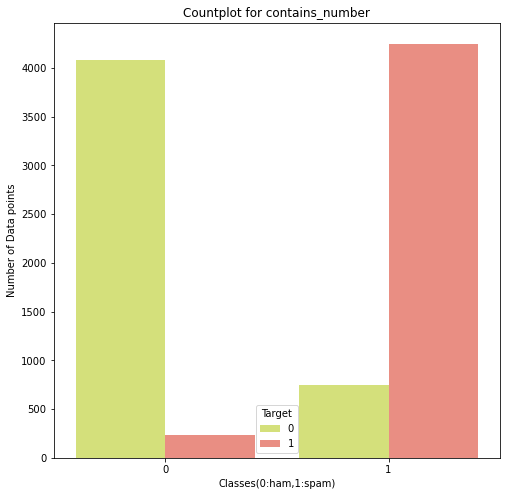

In [46]:
#Palette
cols= ["#E1F16A", "salmon"] 
#countplot for contains_currency_symbol
plt.figure(figsize=(8,8))
fg = sns.countplot(x='contains_number', data=sms_df, hue='Target', palette= cols)
fg.set_title("Countplot for contains_number")
fg.set_xlabel("Classes(0:ham,1:spam)")
fg.set_ylabel("Number of Data points")

**Insight: It is evident that most of the Spam messages contain numbers, and majority of the Ham messages do not contain numbers.**

## Data Preprocessing 

**Steps involve in preprocessing the data for NLP :**

- **cleaning text**:
  - *In the first step we extract only the alphabetic characters by this we are removing punctuation and numbers.*
  - *In the next step, we are converting all the characters into lowercase.* 
  
- **Tokenizing the sms** : *Tokenization is breaking complex data into smaller units called tokens. It can be done by splitting paragraphs into sentences and sentences into words.*


- **Removing the stop words :** *Stopwords are frequently occurring words(such as few, is, an, etc). These words hold meaning in sentence structure, but do not contribute much to language processing in NLP. For the purpose of removing redundancy in our processing, I am removing those. NLTK library has a set of default stopwords that we will be removing.*


- **Lemmatizing the words :** *Stemming and Lemmatization are Text Normalization (or sometimes called Word Normalization) techniques in the field of NLP*
  - *Lemmatization is the process of arriving at a lemma of a word. What is a lemma, then? Lemma is the root from which a word is formed. For example, given the word went, the lemma would be 'go' since went is the past form of go.*


- **Vectorization :** *TF-IDF in NLP stands for Term Frequency – Inverse document frequency. In NLP cleaned data needs to be converted into a numerical format where each word is represented by a matrix. This is also known as word embedding or Word vectorization.Term Frequency (TF) = (Frequency of a term in the document)/(Total number of terms in documents) Inverse Document Frequency(IDF) = log( (total number of documents)/(number of documents with term t)) I will be using TfidfVectorizer() to vectorize the preprocessed data.*

  - **Steps in the Vectorizing:**
   - Creating a corpus of lemmatized text
   - Converting the corpus in vector form

In [47]:
#Lets have a look at a sample of texts before cleaning
print("The First 5 Texts:\0",*sms_df["Message"][:5], sep = "\n")

The First 5 Texts: 
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though


In [48]:
# Cleaning the messages
corpus = []
wnl = WordNetLemmatizer()

for sms_string in list(sms_df.Message):

  # Cleaning special character from the sms
  message = re.sub(pattern='[^a-zA-Z]', repl=' ', string=sms_string)

  # Converting the entire sms into lower case
  message = message.lower()

  # Tokenizing the sms by words
  words = message.split()

  # Removing the stop words
  filtered_words = [word for word in words if word not in set(stopwords.words('english'))]

  # Lemmatizing the words
  lemmatized_words = [wnl.lemmatize(word) for word in filtered_words]

  # Joining the lemmatized words
  message = ' '.join(lemmatized_words)

  # Building a corpus of messages
  corpus.append(message)

In [49]:
corpus[0:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [50]:
#Changing text data in to numbers and Creating the Bag of Words model
tfidf = TfidfVectorizer(max_features=500)
vectors = tfidf.fit_transform(corpus).toarray()
feature_names = tfidf.get_feature_names()

#Let's have a look at our feature 
vectors.dtype

dtype('float64')

## Model Building  

**Steps involved in the Model Building**

- Setting up features and target as X and y
- Splitting the testing and training sets
- Build a pipeline of model for four different classifiers.
  - Naïve Bayes
  - RandomForestClassifier
  - DecisionTreeClassifier
  - Support Vector Machines
- Fit all the models on training data
- Get the cross-validation on the training set for all the models for accuracy

In [51]:
# Extracting independent and dependent variables from the dataset
X = pd.DataFrame(vectors, columns=feature_names)
y = sms_df['Target']

In [52]:
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
#Testing on the following classifiers
classifiers = [MultinomialNB(), 
               RandomForestClassifier(),
               DecisionTreeClassifier(), 
               SVC()]
for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "NaiveBayes", 1: "RandomForest", 2: "DecisionTree",3: "SVC"}

In [54]:
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

NaiveBayes: 0.944391 
RandomForest: 0.994761 
DecisionTree: 0.979449 
SVC: 0.995434 


## Model Evaluation 

**Testing the models on Testset**

- Accuracy Report
- Confusion Matrix

In [55]:
# Model Evaluation
# creating lists of various scores
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [56]:
# initialise data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Testset':testset_accuracy,
'Accuracy on Trainset':trainset_accuracy}
# Creates pandas DataFrame.
Results = pd.DataFrame(data, index =["NaiveBayes", "RandomForest", "DecisionTree","SVC"])

In [57]:
Results 

,Precision,Recall,F1score,Accuracy on Testset,Accuracy on Trainset
NaiveBayes,0.944259,0.936947,0.940589,0.995166,0.99812
RandomForest,0.990110,0.996681,0.993385,0.995166,0.99812
DecisionTree,0.965702,0.996681,0.980947,0.995166,0.99812
SVC,0.993385,0.996681,0.995030,0.995166,0.99812


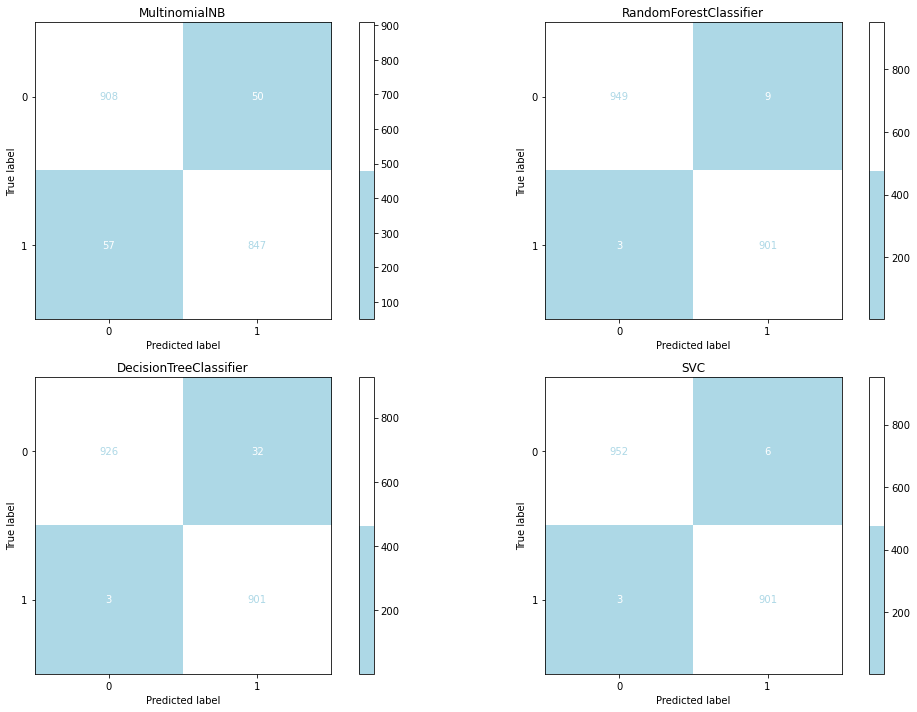

In [64]:
cmap = ListedColormap(["lightblue", "white"])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test, 
                          y_test, 
                          ax=ax, 
                          cmap= cmap,   
                          )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

**Note**:*we can clearly see that Random Forest and Support vector classifier alomost got the same score but with the help of confusion matrix we can say that SVC performed slightly better than the Randon Forest, **hence Support Vector algorithm is selected for predicting the results of this problem statement**.*